In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from keras.models import model_from_json
import numpy as np
import json
import requests
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# ## turn back to main directory
# import os
# os.chdir("../")
# os.getcwd()

In [3]:
df_all = pd.read_csv('data/19999_question_category_a_v16.csv')
df_test = pd.read_csv('data/19999_test_question.csv')
print(f"df_all shape : {df_all.shape}")
print(f"df_test shape : {df_test.shape}")

df_all shape : (14243, 8)
df_test shape : (27, 4)


In [4]:
mapping = df_all.category.astype('category').cat.categories
mapping

# mapping = df_all.network_b_to_a.astype('category').cat.categories
# mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [5]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/Project_19999/19999_CNN/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u1430022de19ce5d7760cc83d31504a1a.cache
Loading model cost 0.528 seconds.
Prefix dict has been built succesfully.


In [6]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,無法
2,安裝


In [7]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [8]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入顯示訊息無效的帳號或不存在帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假要補登先前的加班但開啟camp後出勤表單顯示的內容像測試的沒有的時間也沒辦法使用已...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核bpm有問題都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用camp進行表單簽核動作,4
4,無法打開報單資料,CAMP,CAMP,CAMP,CAMP,資訊系統,無法打開報單資料,4


In [9]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list

In [10]:
# df_test

In [11]:
def cut_to_word(s):
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        combie = combie + w
        if i < len(w_list) - 1:
            combie = combie + ','
            
    return combie    

# print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word(s.strip()))
df_test['cut_words'] = df_test['description_clean'].apply(lambda s: cut_to_word(s.strip()))

In [12]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,網路孔不通 無法連線,網管,網路,電腦網路不通,網路不通 (QRDC),網路,網路孔不通 無法連線,3,"網路,孔,不通,無法,連線"
1,QDSM目前是否可以開放給重慶端使用? 若要使用，是否需要MIS另外設定? 目前在Au...,R&D資訊系統,測試相關服務,【QDSM】測試設備預約管理系統,相關操作詢問,資訊系統,qdsm目前是否可以開放給端使用 若要使用是否需要mis設定 目前在authority...,4,"qdsm,目前,是否,開放給,端,使用,使用,是否,需要,mis,設定,目前,authori..."
2,User帳號想要申請ZMF6的權限 分機是:11593,SAP-168(QCI),Basis,帳號,新申請,SAP,帳號申請zmf6的權限 是,1,"帳號,申請,zmf6,權限,"
3,本機outlook無法收送，寄信時會出現錯誤，收信也無法收 #15846,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,本機outlook無法收送寄信時會收信也無法收,0,"本機,outlook,無法,收送,寄信,時會,收信,無法,收"
4,"有線網路驗證失敗,無法連線",網管,網路,電腦網路不通,網路不通 (QRDC),網路,有線網路驗證失敗無法連線,3,"有線網路,驗證,失敗,無法,連線"


In [13]:
# df_all[3040:4010]

In [14]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

X_test = df_test['cut_words']
y_test = df_test['category_target']


# X = df_all['cut_words']
# y = df_all['network_b_to_a_target']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 40)

In [16]:
X_train.head()

2748                        outlook,無法,打開,福委會,mail
101                    郵件,無法,收發,刪掉,帳號,重新,建,帳號,再,新增
7486                                 第一次,使用,sap,詢問
9039                            網路,不通,孔號,ps05,a413
7906    outlook,收發,信件,異常,時常,收不到,信,發信,失敗,情況,號碼,1357
Name: cut_words, dtype: object

In [17]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))


[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
num_classes = 5


In [18]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 50

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)

    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)
x_test = preprocessing(X_test, max_len=MAX_LEN)

In [19]:
x_train

array([[   0,    0,    0, ...,   86,  617,   13],
       [   0,    0,    0, ...,   37,  153,  149],
       [   0,    0,    0, ...,    5,   14,   60],
       ...,
       [   0,    0,    0, ...,  358, 1023,   75],
       [   0,    0,    0, ...,    0,  406,    4],
       [   0,    0,    0, ...,    4,   55,   93]], dtype=int32)

In [20]:
"""
訓練model
"""
# set parameters:

batch_size = 20
filters = 200
kernel_size = 3
epochs = 50
train_ratio = 0.9

# batch_size = 10
# filters = 50
# kernel_size = 3
# epochs = 50
# train_ratio = 0.8

# maxlen = 100
# embedding_dims = 50
# hidden_dims = 250

In [21]:
# model.add(Conv1D(activation="relu", padding="same", filters=64, kernel_size=5))
# model.add(MaxPooling1D(pool_size=4))

In [22]:
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len, kernel_size=3):
    """
    使用長度不同的filter 對文本矩陣進行卷積，filter的寬度等於詞向量的長度，
    然後使用max-pooling 對每一filter提取的向量進行操作，
    最後每一個filter對應一個數字，把這些filter拼接起來，就得到了一個表徵該句子的向量
    """
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=32, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.75))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [23]:
# def build_1DCNN_model2(num_classes, vocab_size, embedding_size, max_sentence_length, dropout=0.5):
#     model = Sequential()
#     model.add(Embedding(vocab_size,embedding_size,input_length=max_sentence_length))
#     model.add(Dropout(dropout))
    
#     #for filter_size in filter_sizes:
#     model.add(Conv1D(filters,
#                      kernel_size,
#                      padding='valid',
#                      activation='relu',
#                      strides=1))
#     model.add(MaxPooling1D())
#     model.add(Dropout(dropout))
#     model.add(Flatten())
#     model.add(Dense(num_classes ,activation='relu'))
#     model.add(Activation('softmax'))
#     #model.compile(loss=keras.losses.categorical_crossentropy,optimzer=keras.optimizers.SGD(),metrics=['accuracy'])
#     model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
#     return model

In [24]:
model = build_1DCNN_model(num_classes, NUM_WORDS, MAX_LEN, kernel_size)
# model = build_1DCNN_model2(num_classes, NUM_WORDS, 32, MAX_LEN)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            160032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 200)           19400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0     

In [25]:
model_path = '{}.h5'.format('19999_1dcnn')

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

model_history = model.fit(x_train, y_train_one_hot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split= 1 - train_ratio,
          callbacks = [checkpoint, earlystop])

Train on 8973 samples, validate on 997 samples
Epoch 1/50
8973/8973 [==============================] - 3s 352us/step - loss: 1.1430 - acc: 0.5456 - val_loss: 0.6962 - val_acc: 0.7482

Epoch 00001: val_acc improved from -inf to 0.74824, saving model to 19999_1dcnn.h5
Epoch 2/50
8973/8973 [==============================] - 1s 144us/step - loss: 0.6940 - acc: 0.7476 - val_loss: 0.5348 - val_acc: 0.7954

Epoch 00002: val_acc improved from 0.74824 to 0.79539, saving model to 19999_1dcnn.h5
Epoch 3/50
8973/8973 [==============================] - 1s 143us/step - loss: 0.6061 - acc: 0.7751 - val_loss: 0.4866 - val_acc: 0.8024

Epoch 00003: val_acc improved from 0.79539 to 0.80241, saving model to 19999_1dcnn.h5
Epoch 4/50
8973/8973 [==============================] - 1s 143us/step - loss: 0.5427 - acc: 0.8101 - val_loss: 0.4289 - val_acc: 0.8616

Epoch 00004: val_acc improved from 0.80241 to 0.86158, saving model to 19999_1dcnn.h5
Epoch 5/50
8973/8973 [==============================] - 1s 144us

In [26]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


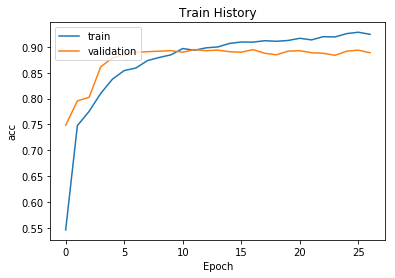

In [27]:
show_train_history(model_history,'acc','val_acc')

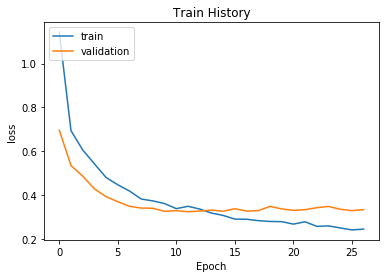

In [28]:
show_train_history(model_history,'loss','val_loss')

In [29]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
    model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict(x_val)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [30]:
answer_name = to_cat_name(y_val)

In [31]:
model.predict_classes(x_val)

array([1, 3, 1, ..., 0, 3, 0])

In [32]:
x_val

array([[   0,    0,    0, ...,  280,  176,  114],
       [   0,    0,    0, ...,    2,    4, 4750],
       [   0,    0,    0, ...,   16,  218, 1178],
       ...,
       [   0,    0,    0, ...,  391, 4071,  175],
       [   0,    0,    0, ...,   24,  108, 1886],
       [   0,    0,    0, ...,    0,    0,    3]], dtype=int32)

In [33]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [34]:
# model.predict(x_val)

In [35]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [36]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [37]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.8993681254388017 !!!!!!!!


In [38]:
# confusion matrix
confusion_matrix = pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'])
confusion_matrix

answer,Outlook與郵件,SAP,其他,網路,資訊系統
predict,,,,,
Outlook與郵件,1184,5,36,21,20
SAP,2,477,22,30,37
其他,14,12,224,32,16
網路,22,20,57,1625,30
資訊系統,7,16,21,10,333


In [39]:
# f, ax = plt.subplots(figsize=(20, 12))
# sns.heatmap(confusion_matrix, annot=True, square=True, fmt='.1f', annot_kws={'size': 10})

In [40]:
"""
預測錯誤的資料觀察
"""
predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
2522,"密碼,過期,無法",2,其他,3,網路,"[0.039553683, 0.034523085, 0.534511, 0.3275311..."
3193,"ssvpn,原件,無法,安裝,成功",2,其他,3,網路,"[0.08204033, 0.0633227, 0.5000554, 0.20223857,..."
5979,"鍵盤,壞掉,按下去,出現,星號",3,網路,2,其他,"[0.064663306, 0.07046686, 0.36106208, 0.414247..."
11557,"申請,網路,顯示,已,申請",3,網路,4,資訊系統,"[0.005783579, 0.014819905, 0.09687052, 0.83603..."
9390,"密碼,後,無法,正常,使用,電腦",2,其他,3,網路,"[0.10059088, 0.09287153, 0.40250522, 0.3072620..."
7595,"新增,線上,會議,選項,不見了,lync,無法,共用,桌面",2,其他,0,Outlook與郵件,"[0.0036032447, 0.00012775032, 0.9542433, 0.011..."
3833,"box,軟體,丟檔,案給,廠商,連不上",0,Outlook與郵件,2,其他,"[0.86519045, 3.445111e-05, 0.102864735, 0.0306..."
6112,"11,申請,訪客,無線網路,單號,12,訪客,登入,今日,19,已,澄清,是否,需要,再次,申請",3,網路,4,資訊系統,"[2.3356638e-06, 0.00089305075, 0.007905751, 0...."
2230,"申請,帳號,似乎,告知,密碼",4,資訊系統,1,SAP,"[0.014618304, 0.34249175, 0.05886072, 0.150185..."
4555,"can,t,find,previos,folder",3,網路,0,Outlook與郵件,"[0.052665517, 0.12610254, 0.105078794, 0.59719..."


In [41]:
"""
自訂測試句子
"""

y_predict_name, y_predict, y_predict_probability = predict(x_test)
answer_name = to_cat_name(y_test)
predict_df = pd.DataFrame({
              '1_sentence':X_test,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_test,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [42]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.8518518518518519 !!!!!!!!


In [43]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'], margins=True)

answer,Outlook與郵件,SAP,其他,網路,資訊系統,All
predict,,,,,,
Outlook與郵件,3,0,0,0,1,4
SAP,0,4,0,0,2,6
其他,0,0,7,0,0,7
網路,0,0,0,1,1,2
資訊系統,0,0,0,0,8,8
All,3,4,7,1,12,27


In [44]:
# predict_df[predict_df['2_y_predict'] == predict_df['4_answer']]

In [45]:
"""
預測錯誤的資料觀察
"""
predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
4,"bms,系統",3,網路,4,資訊系統,"[0.0063371975, 0.023406204, 0.08779862, 0.8053..."
9,"薪資,系統,金額",0,Outlook與郵件,4,資訊系統,"[0.77541745, 0.0049456577, 0.08077583, 0.09709..."
19,"在職,證明",1,SAP,4,資訊系統,"[0.14448151, 0.30378518, 0.14042145, 0.2437374..."
22,"異常,so,簽核,問題",1,SAP,4,資訊系統,"[3.8717917e-06, 0.9923758, 7.920556e-06, 4.667..."


In [46]:
predict_df[predict_df['2_y_predict'] == predict_df['4_answer']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
0,"無法,上面,使用,camp,進行,表單,簽核,動作",4,資訊系統,4,資訊系統,"[7.70622e-08, 7.636051e-07, 0.0007103197, 2.52..."
1,"研發,服務,雲",4,資訊系統,4,資訊系統,"[0.00015624415, 0.0013788742, 0.015511706, 0.0..."
2,"無線網路,不通",3,網路,3,網路,"[8.377891e-09, 1.315955e-08, 0.00022528449, 0...."
3,"out,look,附件",0,Outlook與郵件,0,Outlook與郵件,"[0.38934487, 0.3479081, 0.09478001, 0.10936352..."
5,mro,4,資訊系統,4,資訊系統,"[0.000986663, 0.0030458125, 0.04396452, 0.0135..."
6,"北棟,一樓,警衛,電腦,需要,灌,office",2,其他,2,其他,"[0.0015984401, 0.00039245724, 0.7739411, 0.088..."
7,sap168,1,SAP,1,SAP,"[9.81887e-07, 0.9980509, 1.8956426e-06, 9.2922..."
8,sap268,1,SAP,1,SAP,"[6.6508437e-06, 0.99521255, 1.164311e-05, 4.95..."
10,"採購單,簽核,時,發生,錯誤",4,資訊系統,4,資訊系統,"[0.048097573, 0.025519738, 0.1296654, 0.050426..."
11,"218logon,失敗",1,SAP,1,SAP,"[0.19147542, 0.3387448, 0.12572888, 0.2112104,..."


In [47]:
# model_path = '{}.h5'.format('19999_1dcnn')
# model.save(model_path)

In [48]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)